# Dataset

In [7]:
# hugging face dataset 사용
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
import numpy as np

train = load_dataset('json', data_files='data/Training/02.라벨링데이터/TL_02.RLHF데이터/SFTlabel.json',
                       field='data_info')
valid = load_dataset('json', data_files='data/Validation/02.라벨링데이터/VL/SFTlabel.json',
                       field='data_info')


# 각 카테고리별로 30개씩만 샘플링하는 함수
def sample_balanced_validation(dataset, n_samples_per_category=30):
    df = pd.DataFrame(dataset)
    
    # 카테고리별로 샘플링
    sampled_dfs = []
    for category in df['data_category'].apply(lambda x: x['middle']).unique():
        category_df = df[df['data_category'].apply(lambda x: x['middle']) == category]
        # 만약 카테고리의 샘플 수가 n_samples_per_category보다 적다면 전부 사용
        n_samples = min(len(category_df), n_samples_per_category)
        sampled_df = category_df.sample(n=n_samples, random_state=42)
        sampled_dfs.append(sampled_df)
    
    # 샘플링된 데이터 합치기
    final_df = pd.concat(sampled_dfs).reset_index(drop=True)
    
    # Dataset 형식으로 변환
    return Dataset.from_pandas(final_df)

# 검증 데이터 샘플링
valid_sampled = sample_balanced_validation(valid['train'], n_samples_per_category=10)

# DatasetDict 형태로 합치기
dataset = DatasetDict({
    'train': train['train'],
    'validation': valid_sampled
})

# 필요한 컬럼만 남기기
dataset = dataset.map(lambda x: {
    'input_text': x['question'], 
    'target_text': x['answer']['contents']
})

# 결과 확인
print("전체 validation 데이터 수:", len(dataset['validation']))
temp = pd.DataFrame(dataset['validation']['data_category'])['middle'].value_counts()
print("\n카테고리별 분포:")
print(temp)

Map: 100%|██████████| 100/100 [00:00<00:00, 10201.89 examples/s]

전체 validation 데이터 수: 100

카테고리별 분포:
middle
기타     10
자연     10
예체능    10
공학     10
사회     10
산업     10
인문     10
명칭     10
보건     10
종교     10
Name: count, dtype: int64


In [2]:
import pandas as pd
pd.DataFrame(dataset['train']['data_category'])['main'].unique()

array(['문어체', '구어체', "원문이 해당하는 카테고리는 '문어체'야.", '구어체.',
       "야민 정음을 사용하면 평소에는 어떤 단어가 바뀌는지 알려드리겠습니다. 카테고리 목록 중 하나를 선택해주세요. 카테고리 목록은 다음과 같습니다: ['문어체', '구어체']",
       '예시 답변:\n구어체',
       '생산되는 제품은 다양한 종류가 있지만, 가공업에서 생산되는 제품의 종류로는 음식품, 의류, 가구, 자동차 부품, 전자제품, 기계류 등이 있습니다.',
       '이해했습니다. 원문이 해당하는 카테고리를 주어진 카테고리 목록에서 단 하나만 골라서 단어로만 알려주는 파이썬 코드를 작성해 드리겠습니다.\n\n```python\ncategories = [\'문어체\', \'구어체\']\n원문 = "원하는 텍스트" # 원하는 원문을 입력하세요\n\nfor category in categories:\n    if category in 원문:\n        print(category)\n        break\n```\n\n위의 코드는 원문에서 주어진 카테고리 목록에 해당하는 단어를 찾아내고, 찾은 카테고리를 출력합니다. 이때, 단 하나의 카테고리만 출력하고 루프를 종료하기 위해 `break`문을 사용합니다.\n\n원문 변수에는 원하는 텍스트를 입력하시면 됩니다. 해당하는 카테고리가 없는 경우 아무런 출력이 없을 것입니다. 코드를 실행하면 카테고리가 출력됩니다.',
       '구어체: 걸레, 방청소용 스프레이, 닦는 천, 비누, 장갑', '답변: 구어체',
       "원문이 해당하는 카테고리는 '문어체'입니다.",
       "가공업에서 주로 사용되는 장비는 단어로만 말할 때, 카테고리 '문어체'에 해당합니다.", '문어체.',
       '어류의 다양한 종류에는 다음과 같은 것들이 있습니다.', "'한국고전문학': 문어체\n\n'한국현대문학': 구어체",
       "구조주의의 주요 학자나 대표적인 저작은 '트리스트랑

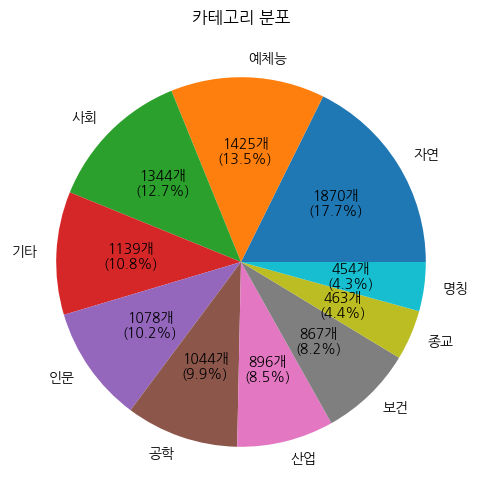

In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumGothic'
temp = pd.DataFrame(dataset['train']['data_category'])['middle'].value_counts()

# autopct 함수로 개수와 퍼센트 모두 표시
def make_autopct(values):
   def my_autopct(pct):
       total = sum(values)
       val = int(round(pct*total/100.0))
       return f'{val}개\n({pct:.1f}%)'
   return my_autopct

plt.figure(figsize=(8,6))
plt.pie(temp.values, labels=temp.index, autopct=make_autopct(temp.values))
plt.title('카테고리 분포')
plt.show()

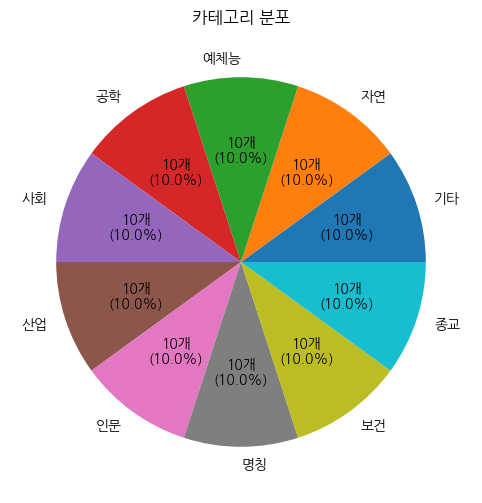

In [4]:
temp = pd.DataFrame(dataset['validation']['data_category'])['middle'].value_counts()

plt.figure(figsize=(8,6))
plt.pie(temp.values, labels=temp.index, autopct=make_autopct(temp.values))
plt.title('카테고리 분포')
plt.show()

In [5]:
lens = list(map(lambda x: len(x),dataset['train']['input_text']))
print(max(lens))
print(sum(lens) / len(lens))
print(min(lens))

107
30.08563327032136
10


In [8]:
dataset['train'][:3]

{'data_id': ['04779be1-67ac-4b70-8dc2-fda6dc353b2a',
  'cb6c0bcf-61c5-4a40-a0ef-b5090b3bac4c',
  '701a4cf9-28ad-4d67-ae35-05963b14683b'],
 'data_category': [{'main': '문어체', 'middle': '공학'},
  {'main': '문어체', 'middle': '보건'},
  {'main': '구어체', 'middle': '보건'}],
 'question_type': ['생성', '생성', '생성'],
 'question_count': [6, 10, 6],
 'question': ['화학공학이 다른 공학 분야와 어떻게 다른가요?',
  '정제 탄수화물과 비정제 탄수화물은 사람의 소화 과정에 어떤 차이점을 보이는가? ',
  '사상의학에서 유전자 분석은 어떻게 활용되고 있나요?'],
 'answer': [{'answer_count': 198,
   'contents': '화학공학은 화학과 공학의 합성으로 이루어진 학문 분야입니다. 다른 일반적인 공학 분야와 비교하여 화학공학은 화학적인 원리와 반응을 토대로 공학적인 설계, 개발, 생산, 운영 등을 수행합니다. 다른 공학 분야와의 차이점은 다음과 같습니다:\n\n1. 전공 과목: 화학공학은 화학, 열역학, 반응공학 등 화학적 원리와 공학적인 계산, 모델링에 대한 교육을 받습니다. 다른 공학 분야는 기계, 전기, 토목 등과 같은 분야별 전공 과목을 강조합니다.\n\n2. 연구 대상: 화학공학은 다양한 종류의 물질과 화학 반응, 원리에 대한 연구를 수행합니다. 다른 공학 분야는 일반적으로 물리적인 시스템, 기계, 구조 등에 관련된 연구를 수행합니다.\n\n3. 산업 분야: 화학공학은 화학 프로세스, 제약, 에너지, 환경, 식품 등 다양한 산업 분야에서 활동합니다. 다른 공학 분야는 해당 분야의 기술과 지식을 적용하여 자동차, 건축, 통신 등 특정한 분야에 전문화됩니다.\n\n4. 실험 및 연

In [9]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
bos_token='</s>', eos_token='</s>', unk_token='<unk>',
pad_token='<pad>', mask_token='<mask>')
tokenizer.tokenize("</s> 안녕하세요. 한국어 GPT-2 입니다.😤:)l^o </s>")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['</s>',
 '▁안녕',
 '하',
 '세',
 '요.',
 '▁한국어',
 '▁G',
 'P',
 'T',
 '-2',
 '▁입',
 '니다.',
 '😤',
 ':)',
 'l^o',
 '▁',
 '</s>']

In [10]:
def preprocess_training_examples(examples):
    max_length = 256
    
    # Format input text with template
    formatted_inputs = [
        f"</s> 질문: {q} 답변: {a} </s>"
        for q, a in zip(examples["input_text"], examples["target_text"])
    ]
    
    # Tokenize inputs
    inputs = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    # Create labels (same as inputs for this format)
    labels = inputs["input_ids"].clone()
    labels[labels == tokenizer.pad_token_id] = -100
    inputs["labels"] = labels
    
    return inputs

# Apply preprocessing
train_dataset = dataset["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset["train"].column_names,
)
validation_dataset = dataset["validation"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset["validation"].column_names,
)

train_dataset.set_format(type='torch')
validation_dataset.set_format(type='torch')

Map: 100%|██████████| 100/100 [00:00<00:00, 2784.27 examples/s]


# Model

In [11]:
import torch
from transformers import GPT2LMHeadModel,  PreTrainedTokenizerFast

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

class LightMetrics:
 

metrics = LightMetrics(tokenizer=tokenizer)

In [ ]:
# 데이터셋과 훈련 횟수와 관련된 하이퍼 파라미터
batch_size = 128 # 총 배치 크기
num_epochs = 50
micro_batch = 16 # GPU당 배치 크기 
gradient_accumulation_steps = batch_size // micro_batch # GPU 메모리 늘리지 않고 더 효과적인 배치처리가 가능

# 훈련 방법에 대한 하이퍼 파라미터
lr_scheduler = 'cosine'
warmup_ratio = 0.06
warmup_steps = 300
learning_rate = 4e-4
optimizer = 'adamw_torch_fused'
weight_decay = 0.01
max_grad_norm = 1.0

# evaluation
evaluation_strategy = 'epoch'
per_device_eval_batch_size= 16
eval_accumulation_steps = 4 # evaluation 메모리 관리

# 로깅, 저장
save_strategy = 'epoch'
save_total_limit = 2
logging_steps = 50

# 저장 경로
output_dir = f"results/kogpt2-{num_epochs}epochs"
logging_dir = f"logs/{output_dir.split('/')[-1]}-logs"

In [12]:
import gc
from typing import Optional
from transformers import Trainer

class CustomTrainer(Trainer):
    def evaluation_loop(self, *args, **kwargs):
        torch.cuda.empty_cache()
        gc.collect()
        return super().evaluation_loop(*args, **kwargs)
    
    def training_step(self, model, inputs, gradient_accumulation_steps: int = 1):
        """training step에서 대부분의 메모리가 누적되므로 주기적 정리
        Args:
            model: 학습 모델
            inputs: 입력 데이터
            gradient_accumulation_steps: gradient accumulation steps
        """
        if self.state.global_step > 0 and self.state.global_step % 100 == 0:  # 100 step마다
            torch.cuda.empty_cache()
            gc.collect()
        return super().training_step(model, inputs, gradient_accumulation_steps)
    
    def save_model(self, output_dir: Optional[str] = None, _internal_call: bool = False):
        """모델 저장은 많은 메모리를 사용하므로 저장 전 정리"""
        torch.cuda.empty_cache()
        gc.collect()
        return super().save_model(output_dir, _internal_call=_internal_call)
    

In [ ]:
from transformers import TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=micro_batch,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    optim=optimizer,
    max_grad_norm=max_grad_norm,
    warmup_steps=warmup_steps,
    warmup_ratio=warmup_ratio,
    weight_decay=weight_decay,
    lr_scheduler_type=lr_scheduler,
    save_strategy=save_strategy,
    save_total_limit=save_total_limit,
    fp16=True,
    logging_steps=logging_steps,
    logging_dir=logging_dir,
    evaluation_strategy=evaluation_strategy,
    per_device_eval_batch_size=per_device_eval_batch_size,
    eval_accumulation_steps=eval_accumulation_steps,
    
    gradient_checkpointing=False,
    # gradient_checkpointing_kwargs={"use_reentrant": False},  # Added: 안정성
    load_best_model_at_end=True,  # Added: 최고 성능 모델 자동 저장
    metric_for_best_model="eval_loss",  # Added: 평가 기준
    save_safetensors=True,  # Added: 더 안전한 저장 포맷
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors='pt', padding=True
    ),
    compute_metrics=metrics
)
# GPU 캐시 설정 최적화
torch.backends.cudnn.benchmark = True
# Start training
torch.cuda.empty_cache()
gc.collect()
trainer.train()
metrics.cleanup()
tokenizer.save_pretrained(output_dir)

Epoch,Training Loss,Validation Loss,Exact Match,F1,Rouge-l
0,3.116100,2.608940,0.000000,42.285706,0.372271
1,2.610700,2.597110,0.000000,42.625344,0.378655
2,2.476700,2.616732,0.000000,41.555043,0.371770
3,2.277200,2.680089,0.000000,41.792832,0.364816
4,2.131500,2.726363,0.000000,40.902709,0.358073
5,1.917800,2.774331,0.000000,37.183269,0.346773
6,1.633000,2.848839,0.000000,37.190063,0.335746
7,1.475900,2.938397,0.000000,34.402405,0.323270
8,1.267400,3.005605,0.000000,34.770048,0.322153
9,1.061400,3.124027,0.000000,35.886703,0.313232


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


In [23]:
text = '근육을 키우려면 어떻게 해야할까요?'
input_text = f"</s> 질문: {text} 답변:"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
gen_ids = model.generate(input_ids,
                         max_length=128,
                         repetition_penalty=2.0,
                         pad_token_id=tokenizer.pad_token_id,
                         eos_token_id=tokenizer.eos_token_id,
                         bos_token_id=tokenizer.bos_token_id,
                         use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

</s> 질문: 근육을 키우려면 어떻게 해야할까요? 답변: 근육이 많은 사람은 체중을 조절하고 근육의 활동을 조절하는 데 매우 중요합니다. 다음은 일반적으로 사용되는 몇 가지 방법입니다 :
1. 균형 잡힌 식단 구성하기 위해 적절한 단백질과 탄수화물을 섭취하세요. 이는 신체 활동량을 증가시키고 근력을 향상시키는 역할을 합니다.
2. 충분한 수면을 취하도록 유도해 주세. 너무 높은 수면 시간을 피하고, 과다한 알코올 섭취를 피하기 위해서는 규칙적인 운동을 통해 에너지를 공급해야 합니다. 또한, 과도한 음주나 과체중 노출은 혈당 상승이나 심장 질환 위험을 높일 수도 있습니다.
3. 스트레스 관리 방법을 찾아보세요.
스트레스


In [ ]:
text = "산림의 주요 기능은 무엇이며, 환경 보호와 관련하여 어떤 역할을 하나요?"
input_text = f"</s> 질문: {text} 답변:"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

gen_ids = model.generate(
    input_ids,
    max_length=256,
    repetition_penalty=2.0,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    use_cache=True,
    top_k=50,
    top_p=0.95,
    temperature=0.5,
    do_sample=True
)

generated = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
print(generated)

질문: 산림의 주요 기능은 무엇이며, 환경 보호와 관련하여 어떤 역할을 하나요? 답변: 산림은 자연환경과 생태계를 보호하고 보호하는 중요한 요소입니다. 다음은 주요한 기능들입니다 :
1. 산림재해 예방 및 관리 시스템 구축 (DRM): 숲을 보호하기 위한 다양한 재해 예방을 위해 숲재해(산사태, 홍수 등)와 같은 자연 재해에 대한 대응 체계를 구축하고 운영합니다. 이를 통해 피해를 최소화하고 적절한 응급 복구를 할 수 있습니다. 
2. 생태계 보전 활동 지원 프로그램 개발(CCPO-Food Programming Systems)
생태계는 생물 다양성, 서식지 파괴 등으로 인해 영향을 받습니다. 이러한 문제를 해결하기 위해서는 생태계의 보전과 복원 프로그램을 개발하고 관리하는 것이 중요합니다.
3. 지속 가능한 자원 관리와 재활용 촉진활동(AESCO-Production Marineup) – 지역의 자원을 보존하고 관리하기 위하여 지역 사회와의 협력을 강화하고 온실가스 배출을 감소시키는 활동을 추진합니다. 이에는 폐기물 처리, 쓰레기 감량, 재생 에너지 활용 등을 포함할 것입니다.
4. 기후변화 협약에 가입하고 대기 오염 방지와 관련된 협약도 체결됩니다.
5. 탄소 감축 캠페인을 주도하거나 관련 프로젝트를 추진하는 등의 활동이 이루어집니다.
6. 국제 협력 강화와 함께 정부 기관들과의 유기적인 협조체계 마련(탄소 포럼)을 구성하여 국가 간 이해관계를 조율하고, 친환경


# 모델 불러오기

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# 특정 체크포인트에서 모델 로드
checkpoint_path = "kogpt2-50epochs/checkpoint-4100"
model = AutoModelForCausalLM.from_pretrained(checkpoint_path).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2",
bos_token='</s>', eos_token='</s>', unk_token='<unk>',
pad_token='<pad>', mask_token='<mask>') # 학습된 토크나이저로 수정 필요

/home/jjlee/miniconda3/envs/kogpt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
text = "산림의 주요 기능은 무엇이며, 환경 보호와 관련하여 어떤 역할을 하나요?"
input_text = f"</s> 질문: {text} 답변:"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to('cuda')

gen_ids = model.generate(
    input_ids,
    max_length=128,
    repetition_penalty=2.0,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    use_cache=True,
    top_k=50,
    top_p=0.95,
    temperature=0.5,
    do_sample=True
)

generated = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
print(generated)

질문: 산림의 주요 기능은 무엇이며, 환경 보호와 관련하여 어떤 역할을 하나요? 답변: 산림은 다양한 기능을 수행합니다. 주요한 기능으로는 다음과 같습니다 :
1. 대기 정화 역할): 산은 땅을 더 얇게 꺼내어 산소를 방출하고, 이산화탄소를 흡수하여 대기를 정화합니다. 이로 인해 공기 질이 향상되고, 개인과 집단의 건강에 긍정적인 영향을 줍니다.
2. 물 관리 문제 해결 부분: 산악 지형이나 강둑 등에서는 지표수를 통해 물을 흡수하고 증발을 방지하여 수분을 충전하는 등의 수질 향상을 가져옵습니다.
3. 토지 보호 및 지하수 보전 영역 등)
4. 생태계 제공과 수확 관리에 기여합니다.
5. 기후 조절 작품 지원 - 건조한 지역에서 녹지 회복을


In [4]:
import gradio as gr
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer

# Special token IDs 확인
bos_token_id = tokenizer.convert_tokens_to_ids('<s>')
eos_token_id = tokenizer.convert_tokens_to_ids('</s>')

def stream_text(text, delay=0.05):
    """텍스트를 한 글자씩 스트리밍하는 함수"""
    partial = ""
    for char in text:
        partial += char
        time.sleep(delay)
        yield partial

def answer(state, state_chatbot, text):
    if not text.strip():
        return state, state_chatbot, state_chatbot
    
    new_state_chatbot = state_chatbot + [(text, None)]
    yield state, new_state_chatbot, new_state_chatbot
    
    # 명확한 구분자를 포함한 프롬프트 구성
    prompt = f"<s>질문: {text}\n답변:"
    
    # 토크나이저 설정 추가
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        return_token_type_ids=False,
        add_special_tokens=True  # 특수 토큰 자동 추가
    ).to('cuda')
    
    # 생성 설정 개선
    gened = model.generate(
        **inputs,
        max_new_tokens=128,
        min_new_tokens=50,
        early_stopping=True,  # EOS 토큰 감지 시 조기 종료
        do_sample=True,
        temperature=0.4,
        top_p=0.95,
        top_k=50,
        repetition_penalty=2.0,
        no_repeat_ngram_size=3,
        bos_token_id=bos_token_id,  # BOS 토큰 ID 명시
        eos_token_id=eos_token_id,  # EOS 토큰 ID 명시
        pad_token_id=tokenizer.pad_token_id,
        forced_eos_token_id=eos_token_id,  # 강제 EOS 토큰 추가
    )

    msg = tokenizer.decode(gened[0], skip_special_tokens=True)  # 특수 토큰 제거
    
    # 응답 추출 로직 개선
    try:
        parts = msg.split("답변:")
        if len(parts) > 1:
            msg = parts[1].split("</s>")[0].strip()  # EOS 토큰 이후 텍스트 제거
        else:
            msg = parts[0].strip()
    except:
        msg = msg.strip()

    # 스트리밍 및 상태 업데이트
    for partial in stream_text(msg):
        new_state_chatbot = state_chatbot + [(text, partial)]
        yield state, new_state_chatbot, new_state_chatbot
    
    state = state + [(text, msg)]
    state_chatbot = state_chatbot + [(text, msg)]
    yield state, state_chatbot, state_chatbot

# 카카오톡 스타일의 CSS
custom_css = """
#chat-container {
    max-width: 800px;
    height: 600px;
    margin: 0 auto;
    background-color: #f5f6f8;
    border-radius: 8px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
    display: flex;
    flex-direction: column;
}

#chatbot {
    flex-grow: 1;
    overflow-y: auto;
    padding: 20px;
    background-color: #b2c7d9;
}

/* 아바타 이미지 크기 조절을 위한 CSS */
#chatbot .avatar {
    width: 28px !important;  100px;
    height: 28px !important; 100px;
    border-radius: 50% !important;
    margin-right: 8px !important ;
}

#chatbot .user-message {
    background-color: #ffeb33;
    color: #333;
    border-radius: 4px;
    padding: 8px 12px;
    margin: 4px 0;
    max-width: 70%;
    align-self: flex-end;
    word-wrap: break-word;
    margin-left: 30%;
}

#chatbot .bot-message {
    background-color: #ffffff;
    color: #333;
    border-radius: 4px;
    padding: 8px 12px;
    margin: 4px 0;
    max-width: 70%;
    align-self: flex-start;
    word-wrap: break-word;
    margin-right: 30%;
}

/* 메시지 컨테이너 정렬을 위한 추가 CSS */
#chatbot .message {
    display: flex !important;
    align-items: flex-start !important;
    margin-bottom: 12px !important;
}

#input-container {
    display: flex;
    align-items: center;
    gap: 10px;
    padding: 12px 16px;
    background-color: #ffffff;
    border-top: 1px solid #eee;
}

#input-box {
    flex-grow: 1;
    border: 1px solid #ddd;
    border-radius: 21px;
    padding: 8px 16px;
    min-height: 42px;
    background-color: #ffffff;
}

#send-button {
    background-color: #ffeb33 !important;
    border: none !important;
    border-radius: 21px !important;
    padding: 8px 20px !important;
    color: #333 !important;
    font-weight: bold !important;
}

.gradio-container {
    max-width: 850px !important;
}

#header {
    background-color: #ffeb33;
    padding: 12px 20px;
    border-radius: 8px 8px 0 0;
    margin-bottom: 0;
    text-align: center;
}

#header h1 {
    margin: 0;
    color: #333;
    font-size: 1.2em;
    font-weight: bold;
}
"""


# Gradio Interface
with gr.Blocks(css=custom_css) as demo:
    state = gr.State([])
    state_chatbot = gr.State([])

    with gr.Column():
        gr.HTML(
            """<div id="header">
                <h1>KoGPT2 와의 대화</h1>
            </div>"""
        )
        
        with gr.Column(elem_id="chat-container"):
            chatbot = gr.Chatbot(
                elem_id="chatbot",
                show_label=False,
                avatar_images=["user.png", "assistant.png",],
            )
            
            with gr.Row(elem_id="input-container"):
                txt = gr.Textbox(
                    show_label=False,
                    placeholder="메시지를 입력하세요...",
                    elem_id="input-box"
                )
                submit_btn = gr.Button("전송", elem_id="send-button")

    # Event handlers
    txt_msg = txt.submit(answer, [state, state_chatbot, txt], [state, state_chatbot, chatbot])
    txt_msg.then(lambda: "", None, txt)
    
    submit_btn.click(answer, [state, state_chatbot, txt], [state, state_chatbot, chatbot])
    submit_btn.click(lambda: "", None, txt)

# Launch the app
demo.launch(debug=True, share=True, server_name="0.0.0.0")

/home/jjlee/miniconda3/envs/kogpt/lib/python3.12/site-packages/gradio/components/chatbot.py:223: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://0.0.0.0:7861
* Running on public URL: https://fa1af8e9a3d8ed4a5d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/home/jjlee/miniconda3/envs/kogpt/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7861 <> https://fa1af8e9a3d8ed4a5d.gradio.live
